In [1]:
# @title Imports

import os
import math
import time
import torch
import nbimporter
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from tempfile import TemporaryDirectory
from models._utils import NeuralTransformer
from utils import DEVICE, BLOCK_SIZE, NUM_TOKENS
from datasets import load_dataset as load_hf_dataset
from CreateSyntheticDataset import tokenize_and_chunk  # works because of nbimporter

CUDA device found.


## Language modeling with tiny Shakespeare

In [2]:
# @title HuggingFace Tokenizers
# @markdown Note there are two ways to call the tokenizer's encoder.

# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("google/byt5-large")

expl_text = "Welcome to the 🤗 Tokenizers library."
impl_text = "We are very happy to show you the 🤗 Transformers library."
expl_encode = tokenizer.encode(expl_text)
impl_encode = tokenizer(impl_text)
print(
    f"Calling `tokenizer.encode(text)`:\n\ttext: {expl_text}\n\ttokenized: {expl_encode}\n\tdecoded: {tokenizer.decode(expl_encode)}",
    end="\n\n",
)
print(
    f"Calling `tokenizer(text)`:\n\tobject.keys(): {impl_encode.keys()}\n\ttext: {impl_text}\n\ttokenized: {impl_encode['input_ids']}\n\tdecoded: {tokenizer.decode(impl_encode['input_ids'])}",
    end="\n\n",
)

Calling `tokenizer.encode(text)`:
	text: Welcome to the 🤗 Tokenizers library.
	tokenized: [90, 104, 111, 102, 114, 112, 104, 35, 119, 114, 35, 119, 107, 104, 35, 243, 162, 167, 154, 35, 87, 114, 110, 104, 113, 108, 125, 104, 117, 118, 35, 111, 108, 101, 117, 100, 117, 124, 49, 1]
	decoded: Welcome to the 🤗 Tokenizers library.</s>

Calling `tokenizer(text)`:
	object.keys(): dict_keys(['input_ids', 'attention_mask'])
	text: We are very happy to show you the 🤗 Transformers library.
	tokenized: [90, 104, 35, 100, 117, 104, 35, 121, 104, 117, 124, 35, 107, 100, 115, 115, 124, 35, 119, 114, 35, 118, 107, 114, 122, 35, 124, 114, 120, 35, 119, 107, 104, 35, 243, 162, 167, 154, 35, 87, 117, 100, 113, 118, 105, 114, 117, 112, 104, 117, 118, 35, 111, 108, 101, 117, 100, 117, 124, 49, 1]
	decoded: We are very happy to show you the 🤗 Transformers library.</s>



In [3]:
# @title HuggingFace Datasets

text_dataset = load_hf_dataset("tiny_shakespeare")
print(text_dataset, end="\n\n")
print("~~~" * 50, end="\n\n")

print(
    "train:",
    type(text_dataset["train"]["text"]),
    len(text_dataset["train"]["text"]),
    type(text_dataset["train"]["text"][0]),
    len(text_dataset["train"]["text"][0]),
    end="\n\n",
)
print(
    "validation:",
    type(text_dataset["validation"]["text"]),
    len(text_dataset["validation"]["text"]),
    type(text_dataset["validation"]["text"][0]),
    len(text_dataset["validation"]["text"][0]),
    end="\n\n",
)
print(
    "test:",
    type(text_dataset["test"]["text"]),
    len(text_dataset["test"]["text"]),
    type(text_dataset["test"]["text"][0]),
    len(text_dataset["test"]["text"][0]),
    end="\n\n",
)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train: <class 'list'> 1 <class 'str'> 1003854

validation: <class 'list'> 1 <class 'str'> 55770

test: <class 'list'> 1 <class 'str'> 55770



In [4]:
# @title Tokenization and Chunking
# @markdown Apply the tokenization and chunking to each split.

text_dataset = text_dataset.map(
    tokenize_and_chunk, batched=True, fn_kwargs=dict(tokenizer=tokenizer)
)
print(text_dataset, end="\n\n")
print("~~~" * 50, end="\n\n")

print(
    "text_dataset['train']['input_ids']:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"]),
    "\n\tlength:",
    len(text_dataset["train"]["input_ids"]),
    end="\n\n",
)
print(
    "text_dataset['train']['input_ids'][0]:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"][0]),
    "\n\tlength:",
    len(text_dataset["train"]["input_ids"][0]),
    end="\n\n",
)
print(
    "text_dataset['train']['input_ids'][0][0]:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"][0][0]),
    "\n\tvalue:",
    text_dataset["train"]["input_ids"][0][0],
    end="\n\n",
)
print("~~~" * 50, end="\n\n")

print(f"Original sequence (text):\n\t{text_dataset['train']['text'][0]}", end="\n\n")
print(
    f"Encoded sequence (tokens):\n\t {text_dataset['train']['input_ids'][0]}",
    end="\n\n",
)
print(
    f"Decoded sequence (tokens):\n\t {tokenizer.decode(text_dataset['train']['input_ids'][0])}",
    end="\n\n",
)

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1963
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 109
    })
})

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

text_dataset['train']['input_ids']:
 	type: <class 'list'> 
	length: 1963

text_dataset['train']['input_ids'][0]:
 	type: <class 'list'> 
	length: 506

text_dataset['train']['input_ids'][0][0]:
 	type: <class 'int'> 
	value: 73

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Original sequence (text):
	First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citi

In [5]:
# @title Define the Transformer model


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)  # batch_first=True
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


class TransformerModel(torch.nn.Module):
    def __init__(
        self,
        ntoken: int,
        d_model: int,
        nhead: int,
        d_hid: int,
        nlayers: int,
        dropout: float = 0.5,
    ):
        super().__init__()
        self.model_type = "Transformer"
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(
            d_model, nhead, d_hid, dropout, batch_first=True
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.embedding = torch.nn.Embedding(ntoken, d_model)
        self.linear = torch.nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape [batch_size, seq_len]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [batch_size, seq_len, ntoken]
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            src_mask = torch.nn.Transformer.generate_square_subsequent_mask(
                src.size(1)  # Use src.size(1) to get the seq_len
            ).to(
                src.device
            )  # Use src.device to match device of src
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

    @torch.no_grad()
    def generate(
        self,
        idx: torch.LongTensor,
        max_new_tokens: int,
        temperature=1.0,
        top_k=None,
    ):
        """
        Special generate method for the Transformer model.
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Since we trained the model to directly predict the next token we take the index as the argmin
        over the distance between the output and the embedding table.
        """
        # Set model to evaluation mode
        self.eval()

        # Loop through time
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= BLOCK_SIZE else idx[:, -BLOCK_SIZE:]
            # forward the model to get the output
            outputs = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = outputs[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
            # apply softmax to convert logits to (normalized) probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1).view(1, 1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [6]:
# @title Initiate an instance

ntokens = tokenizer.vocab_size
emsize = 302  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention (NOTE: nhead must be a divisor of d_hid)
dropout = 0.1  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(DEVICE)
print(f"Vocab size (i.e. num tokens) = {ntokens}")
print(f"Number of attn heads = {nhead}\n")

Vocab size (i.e. num tokens) = 256
Number of attn heads = 2



In [7]:
# @title Train the Transformer model


def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.0
    log_interval = 300
    start_time = time.time()
    global epoch, optimizer, scheduler, criterion

    num_batches = len(text_dataset["train"]["input_ids"])
    for batch in range(num_batches):
        tokens = text_dataset["train"]["input_ids"][batch]
        # parse into input and target
        input = torch.LongTensor(tokens[:-1]).unsqueeze(0).to(DEVICE)  # ``[batch_size=1, seq_len]``
        target = (
            torch.LongTensor(tokens[1:]).unsqueeze(0).reshape(-1).to(DEVICE)
        )  # ``[batch_size=1 * seq_len]``
        # forward pass
        output = model(input)  # ``[batch_size=1, seq_len, ntokens]``
        output_flat = output.view(-1, ntokens)  # ``[batch_size=1 * seq_len, ntokens]``
        # backpropagation step
        optimizer.zero_grad()
        loss = criterion(output_flat, target)
        # check if the computed loss requires gradient
        if loss.requires_grad:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(
                f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                f"lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | ppl {ppl:8.2f}"
            )
            total_loss = 0
            start_time = time.time()


def evaluate(model: torch.nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        num_batches = len(text_dataset["validation"]["input_ids"])
        for batch in range(num_batches):
            tokens = text_dataset["validation"]["input_ids"][batch]
            input = torch.LongTensor(tokens[:-1]).unsqueeze(0).to(DEVICE)
            target = torch.LongTensor(tokens[1:]).unsqueeze(0).reshape(-1).to(DEVICE)
            seq_len = input.size(1)
            output = model(input)
            output_flat = output.view(-1, ntokens)
            total_loss += criterion(output_flat, target).item()
    return total_loss / num_batches

In [8]:
# @markdown Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

criterion = torch.nn.CrossEntropyLoss()  # loss function
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

best_val_loss = float("inf")
epochs = 0

# Load the previously saved best model checkpoint if it exists
final_model_params_path = os.path.join("../models/", "shakespeare_transformer_model.pt")
if os.path.exists(final_model_params_path):
    print("Loading a previously saved model checkpoint...")
    model.load_state_dict(torch.load(final_model_params_path))
    best_val_loss = evaluate(model)

# Train the model
if epochs > 0:
    print(f"Training for {epochs} epoch(s)...\n")
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            train(model)
            val_loss = evaluate(model)
            val_ppl = math.exp(val_loss)
            elapsed = time.time() - epoch_start_time
            print("-" * 89)
            print(
                f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
                f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}"
            )
            print("-" * 89)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"Saving the newest best model...\n")
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step()

        print(f"Saving the overall best model..\n.")
        model.load_state_dict(torch.load(best_model_params_path))
        torch.save(
            model.state_dict(),
            final_model_params_path,
        )  # save the best model for later use

In [9]:
# @title Generate new text using test input

max_new_tokens = 100
idx = torch.LongTensor(text_dataset["test"]["input_ids"][0]).unsqueeze(0).to(DEVICE)
idx_gen = model.generate(idx, max_new_tokens, top_k=None)

print(idx.shape, idx_gen.shape, end="\n\n")
print(tokenizer.decode(idx.tolist()[0]), end="\n\n")
print(tokenizer.decode(idx_gen.tolist()[0][-max_new_tokens:]), end="\n\n")

torch.Size([1, 511]) torch.Size([1, 611])

rance ta'en As shall with either part's agreement stand? BAPTISTA: Not in my house, Lucentio; for, you know, Pitchers have ears, and I have many servants: Besides, old Gremio is hearkening still; And happily we might be interrupted. TRANIO: Then at my lodging, an it like you: There doth my father lie; and there, this night, We'll pass the business privately and well. Send for your daughter by your servant here: My boy shall fetch the scrivener presently. The worst is this, that, at so slender warning, You</s>

5-#I^Qz7gx(x^s8X+#,Ə>23A`߼^3@W߆D



## Neural data modeling

In [10]:
# @title Create neural datasets
# @markdown A synthetic dataset where the neural activity is the embeddings of tokens from the tiny Shakespeare.

ntokens = tokenizer.vocab_size
emsize = 302
d_hid = 512
embedding = torch.nn.Embedding(ntokens, emsize, _freeze=True)  # fixed embedding map

train_dataset = [
    torch.vstack([embedding(token) for token in torch.LongTensor(sequence)])
    for sequence in text_dataset["train"]["input_ids"]
]
validation_dataset = [
    torch.vstack([embedding(token) for token in torch.LongTensor(sequence)])
    for sequence in text_dataset["validation"]["input_ids"]
]
test_dataset = [
    torch.vstack([embedding(token) for token in torch.LongTensor(sequence)])
    for sequence in text_dataset["test"]["input_ids"]
]

# get a test sample for an example
data = train_dataset[0].unsqueeze(0)
print("data: ", data.shape, data.dtype, data.requires_grad, data.device, end="\n\n")

mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0)
print("mask:", mask.shape, mask.dtype, mask.requires_grad, mask.device, end="\n\n")

data:  torch.Size([1, 506, 302]) torch.float32 False cpu

mask: torch.Size([1, 302]) torch.bool False cpu



In [11]:
# @title Create a NeuralTransformer model

model = NeuralTransformer(
    input_size=emsize,
    hidden_size=d_hid,
    version_2=True,
    num_tokens=NUM_TOKENS // 2,
    multi_channel=False,
    vq_vae=False,
).to(DEVICE)

print(f"Vocab size (i.e. num tokens) = {ntokens}")
print(f"Model internal tokens = {model.num_tokens}")
print(f"Number of attn heads = {model.num_heads}\n")

Vocab size (i.e. num tokens) = 256
Model internal tokens = 1024
Number of attn heads = 4



In [12]:
# DEBUG
non_zero_rows = torch.any(model.token_neural_map != 0, dim=1)
non_zero_indices = torch.nonzero(non_zero_rows).squeeze().tolist()
print(len(non_zero_indices), len(model.tokens_experience))
print(model.codebook.requires_grad, model.codebook.grad, model.codebook.grad_fn)

0 0
True None None


In [13]:
# @title Test input-output functionality

mask = mask.to(DEVICE)
input = data[:, :-1, :].to(DEVICE)
target = data[:, 1:, :].to(DEVICE)
with torch.no_grad():
    output = model(input, mask)


print(
    "input:",
    input.shape,
    input.dtype,
    input.requires_grad,
    input.device,
    end="\n\n",
)
print(
    "target:",
    target.shape,
    target.dtype,
    target.requires_grad,
    target.device,
    end="\n\n",
)
print(
    "output:",
    output.shape,
    output.dtype,
    output.requires_grad,
    output.device,
    end="\n\n",
)

input: torch.Size([1, 505, 302]) torch.float32 False cuda:0

target: torch.Size([1, 505, 302]) torch.float32 False cuda:0

output: torch.Size([1, 505, 1024]) torch.float16 False cuda:0



In [14]:
# DEBUG
non_zero_rows = torch.any(model.token_neural_map != 0, dim=1)
non_zero_indices = torch.nonzero(non_zero_rows).squeeze().tolist()
print(len(non_zero_indices), len(model.tokens_experience))
print(model.codebook.requires_grad, model.codebook.grad, model.codebook.grad_fn)

0 0
True None None


In [15]:
# @title Train the NeuralTransformer model


def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.0
    log_interval = 300
    start_time = time.time()
    global epoch, optimizer, scheduler

    num_batches = len(train_dataset)
    for batch in range(num_batches):
        data = train_dataset[batch].unsqueeze(0)
        mask = mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0)
        # parse into input and target
        mask = mask.to(DEVICE)
        input = data[:, :-1, :].to(DEVICE)
        target = data[:, 1:, :].to(DEVICE)
        # forward pass
        output = model(input, mask)  # ``[batch_size=1, seq_len, ntokens]``
        # backpropagation step
        optimizer.zero_grad()
        loss = model.loss_fn()(
            output, target, mask
        )  # flatens output to ``[batch_size=1 * seq_len, ntokens]``
        # check if the computed loss requires gradient
        if loss.requires_grad:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            try:
                ppl = math.exp(cur_loss)
            except OverflowError:
                ppl = float("inf")
            print(
                f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                f"lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | ppl {ppl:8.2f}"
            )
            total_loss = 0
            start_time = time.time()


def evaluate(model: torch.nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        num_batches = len(validation_dataset)
        for batch in range(num_batches):
            data = validation_dataset[batch].unsqueeze(0)
            mask = mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0)
            mask = mask.to(DEVICE)
            input = data[:, :-1, :].to(DEVICE)
            target = data[:, 1:, :].to(DEVICE)
            output = model(input, mask)
            loss = model.loss_fn()(output, target, mask)
            total_loss += loss.item()

    return total_loss / num_batches

In [16]:
# @markdown Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

best_val_loss = float("inf")
epochs = 1

# Load the previously saved best model checkpoint if it exists
final_model_params_path = os.path.join("../models/", "neural_transformer_model.pt")
if os.path.exists(final_model_params_path):
    print("Loading a previously saved model checkpoint...")
    model.load_state_dict(torch.load(final_model_params_path))
    best_val_loss = evaluate(model)

# Train the model
if epochs > 0:
    print(f"Training for {epochs} epoch(s)...\n")
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            train(model)
            val_loss = evaluate(model)
            try:
                val_ppl = math.exp(val_loss)
            except OverflowError:
                val_ppl = float("inf")
            elapsed = time.time() - epoch_start_time
            print("-" * 89)
            print(
                f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
                f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}"
            )
            print("-" * 89)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"Saving the newest best model...\n")
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step()

        # print(f"Saving the overall best model..\n.")
        # model.load_state_dict(torch.load(best_model_params_path))
        # torch.save(
        #     model.state_dict(),
        #     final_model_params_path,
        # )  # save the best model for later use

Training for 1 epoch(s)...

token_sequence_flat (len, min, max) : 	 (505, 41, 946)

unique tokens this batch (count) : 	 32

unique neural vectors this batch (count, dimension) : 	 (44, 302)

num. vectors mapped to same token = 	 12

total unique tokens experienced so far : 	 32

test_token = 	 867

occurrences of test_token = 	 (14, [[0], [38], [80], [97], [171], [186], [195], [205], [213], [273], [292], [329], [455], [481]])

test_token in tokens_experience? : 	 True

token_sequence_flat (len, min, max) : 	 (505, 41, 946)

unique tokens this batch (count) : 	 33

unique neural vectors this batch (count, dimension) : 	 (45, 302)

num. vectors mapped to same token = 	 12

total unique tokens experienced so far : 	 33

test_token = 	 516

occurrences of test_token = 	 (35, [[0], [6], [8], [80], [86], [88], [126], [140], [171], [177], [179], [186], [203], [211], [215], [220], [273], [279], [281], [295], [300], [337], [353], [375], [389], [392], [421], [423], [445], [447], [455], [461], [

token_sequence_flat (len, min, max) : 	 (503, 41, 946)

unique tokens this batch (count) : 	 33

unique neural vectors this batch (count, dimension) : 	 (44, 302)

num. vectors mapped to same token = 	 11

total unique tokens experienced so far : 	 39

test_token = 	 742

occurrences of test_token = 	 (3, [[0], [124], [472]])

test_token in tokens_experience? : 	 True

token_sequence_flat (len, min, max) : 	 (503, 41, 946)

unique tokens this batch (count) : 	 34

unique neural vectors this batch (count, dimension) : 	 (45, 302)

num. vectors mapped to same token = 	 11

total unique tokens experienced so far : 	 39

test_token = 	 438

occurrences of test_token = 	 (72, [[0], [2], [19], [22], [26], [29], [41], [45], [46], [49], [53], [67], [72], [78], [80], [83], [87], [92], [106], [107], [110], [115], [117], [121], [134], [157], [164], [171], [172], [174], [186], [205], [206], [212], [218], [246], [259], [282], [283], [286], [290], [294], [295], [298], [301], [303], [316], [327], [33

Why does the token neural map not correspond to tokens experienced?

Because some of vectors (embeddings) are getting mapped to the same internal token in the model.

In [17]:
# DEBUG
non_zero_rows = torch.any(model.token_neural_map != 0, dim=1)
non_zero_indices = torch.nonzero(non_zero_rows).squeeze().tolist()

print(len(non_zero_indices), len(model.tokens_experience))

print(min(model.tokens_experience), max(model.tokens_experience))
print(min(non_zero_indices), max(non_zero_indices))

print(sorted(model.tokens_experience))
print(sorted(non_zero_indices))

print(model.codebook.requires_grad, model.codebook.grad, model.codebook.grad_fn)

46 50
41 1010
41 946
[41, 58, 102, 105, 112, 128, 208, 227, 231, 240, 247, 271, 282, 312, 355, 358, 361, 389, 411, 438, 439, 455, 481, 492, 493, 516, 525, 539, 551, 576, 580, 590, 612, 632, 633, 674, 679, 713, 736, 737, 742, 747, 762, 763, 811, 846, 867, 878, 946, 1010]
[41, 58, 102, 112, 128, 208, 227, 231, 240, 247, 271, 282, 312, 355, 358, 361, 389, 438, 439, 455, 481, 492, 493, 516, 525, 539, 551, 580, 590, 612, 632, 633, 674, 679, 713, 736, 737, 742, 747, 762, 763, 811, 846, 867, 878, 946]
True None None


In [18]:
real_train_tokens = set()
for sequence in text_dataset["train"]["input_ids"]:
    tokens = set(sequence[:-1])
    real_train_tokens.update(tokens)

print(len(real_train_tokens), "\t", real_train_tokens)
print("\t", tokenizer.decode(list(real_train_tokens)))
print("\n", "~" * 99, "\n")
print(len(model.tokens_experience), "\t", model.tokens_experience)  # DEBUG

64 	 {35, 36, 39, 41, 42, 47, 48, 49, 54, 61, 62, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125}
	 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

50 	 {516, 525, 271, 282, 539, 551, 41, 811, 312, 58, 576, 580, 590, 846, 867, 612, 355, 358, 102, 361, 105, 878, 112, 632, 633, 128, 389, 411, 674, 679, 946, 438, 439, 455, 713, 208, 736, 737, 481, 227, 742, 231, 747, 492, 493, 240, 1010, 247, 762, 763}


Understanding `index_add_` and `scatter_add_`.

In [19]:
x = torch.zeros(5, 3)
t = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
idx = torch.tensor([4, 4, 4])
print(f"self = x \n {x}")
# INDEX_ADD_: the dim-th dimension of source must have the same size as the length of index (which must be a vector), and all other dimensions must match self
print(x.index_add_(0, index=idx, source=t))
# SCATTER_ADD_: self, source, and index must have the same number of dimensions
print(x.scatter_add_(0, index=idx.unsqueeze(-1), src=t))

self = x 
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [12., 15., 18.]])
tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [24., 15., 18.]])


In [20]:
# @title Generate new data

data = train_dataset[0].unsqueeze(0).to(DEVICE)
mask = torch.ones(emsize, dtype=torch.bool).unsqueeze(0).to(DEVICE)
embedding = embedding.to(DEVICE)

max_new_tokens = 100
data_gen = model.generate(data, mask, max_new_tokens, autoregressive=True, top_k=None)

print(mask.shape, data.shape, data_gen.shape, embedding.weight.shape, end="\n\n")

torch.Size([1, 302]) torch.Size([1, 506, 302]) torch.Size([1, 100, 302]) torch.Size([256, 302])



In [21]:
# @markdown We want to embed the neural data.
# We can do this by using the tokenize_neural_data method of our model by passing it
# an embedding matrix of all the tokens in the vocabulary. The method finds the index.

# First run a test on data we know what the true token output should be.
# This is just to confirm if our tokenize_neural_data method is working as expected.
with torch.no_grad():
    sequence = data
    tokens = model.tokenize_neural_data(
        neural_sequence=data,
        feature_mask=mask,
        token_matrix=embedding.weight,
    )
    # iff correct these two should match
    print(text_dataset["train"]["input_ids"][0], end="\n\n")
    print(tokens.squeeze().tolist(), end="\n\n")
    # decode into text
    print(tokenizer.decode(tokens.squeeze().tolist()), end="\n\n")

[73, 108, 117, 118, 119, 35, 70, 108, 119, 108, 125, 104, 113, 61, 35, 69, 104, 105, 114, 117, 104, 35, 122, 104, 35, 115, 117, 114, 102, 104, 104, 103, 35, 100, 113, 124, 35, 105, 120, 117, 119, 107, 104, 117, 47, 35, 107, 104, 100, 117, 35, 112, 104, 35, 118, 115, 104, 100, 110, 49, 35, 68, 111, 111, 61, 35, 86, 115, 104, 100, 110, 47, 35, 118, 115, 104, 100, 110, 49, 35, 73, 108, 117, 118, 119, 35, 70, 108, 119, 108, 125, 104, 113, 61, 35, 92, 114, 120, 35, 100, 117, 104, 35, 100, 111, 111, 35, 117, 104, 118, 114, 111, 121, 104, 103, 35, 117, 100, 119, 107, 104, 117, 35, 119, 114, 35, 103, 108, 104, 35, 119, 107, 100, 113, 35, 119, 114, 35, 105, 100, 112, 108, 118, 107, 66, 35, 68, 111, 111, 61, 35, 85, 104, 118, 114, 111, 121, 104, 103, 49, 35, 117, 104, 118, 114, 111, 121, 104, 103, 49, 35, 73, 108, 117, 118, 119, 35, 70, 108, 119, 108, 125, 104, 113, 61, 35, 73, 108, 117, 118, 119, 47, 35, 124, 114, 120, 35, 110, 113, 114, 122, 35, 70, 100, 108, 120, 118, 35, 80, 100, 117, 102, 1

In [22]:
# Now do the same thing on the newly generated data
with torch.no_grad():
    sequence = data_gen
    tokens = model.tokenize_neural_data(
        neural_sequence=sequence,
        feature_mask=mask,
        token_matrix=embedding.weight,
    )
    print(tokens.squeeze().tolist(), end="\n\n")
    # decode into text
    print(tokenizer.decode(tokens.squeeze().tolist()), end="\n\n")

[10, 35, 103, 35, 103, 35, 104, 114, 35, 104, 1, 10, 35, 122, 35, 1, 10, 35, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87, 68, 83, 87]

 d d eo e</s> w </s> TAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPTAPT



torch.Size([1024, 302]) torch.Size([256, 302])


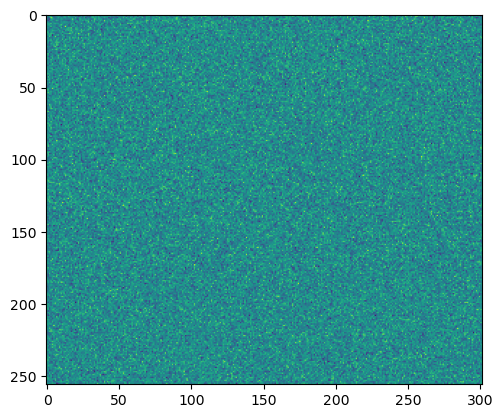

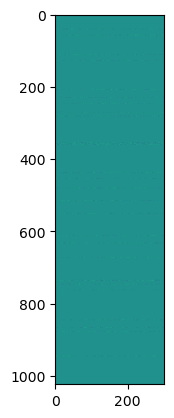

In [23]:
# (num_embeddings == num_tokens, embedding_dim == input_size)
print(model.token_neural_map.shape, embedding.weight.shape)

plt.imshow(embedding.weight.cpu().numpy())
plt.show()

plt.imshow(model.token_neural_map.cpu().numpy())
plt.show()